In [2]:
import math
import numpy as np
import random as rand
from numba import jit,int64,float64
import matplotlib.pyplot as plt
%matplotlib inline

#To increase cell width:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [80]:
#The spacetime parameters. Let the population distribution of gene expression level be g:
g_min = 0
g_max = 100
dg = 0.4
#Defining a g_ghost which contains two extra `ghost' points at the edges:
g_ghost = np.arange(g_min-dg,g_max+2*dg,dg)
g = np.array(g_ghost[1:-1])


#Time:
dt = 0.00016
T = 20
Nt = round(T/dt)
TimeRange = np.arange(0,T,dt)

#How the population distributions evolve in the absence of selection. First, we define the free parameters...
#...K and alpha, and from those D. K sets the timescale of population response to the regulated mean...
#...which is set instantaneously. We may choose time units such that K=1.
K = 1
#The strength of noise:
alpha = 1
#The spread, with the preferred expression level (peak) now set to 50% of maximum.:
g_peak = 0.5*(g_min+g_max)
D = alpha*K*g_peak

#Checks:
print(f"K = {K}; 0.5*dg/dt = {0.5*dg/dt}")
print(f"D = {D}; 0.5*dg**2/dt = {0.5*dg**2/dt}")

#Stability check:
flag_stability=0
if (K>=int(0.5*dg/dt) or D>=int(0.5*dg**2/dt)):
    flag_stability=1
    print("Warning! FTCS unstable.")
    
#Now let's add selection to the picture. First, defining the relative differential growth rate delta. We multiply this by 0.17/g_max to get Dekel delta.
delta = .17/g_max

#Color-blind friendly colors to plot:
CB_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

K = 1; 0.5*dg/dt = 1250.0
D = 50.0; 0.5*dg**2/dt = 500.00000000000006


In [8]:
#First derivative, central difference method (used in the potential term K*d/dg (g*P)):
@jit("float64[:](float64[:],float64)",nopython=True)
def derv1(func,dx):
    func_left = func[0:-2]
    func_right = func[2:]
    #Below we calculate the first derivative using the central difference method:
    derivative = (func_right - func_left)/(2*dx)
    return derivative

#Second derivative using central difference, used in the diffusion term (D*d2/dg2 (P)):
@jit("float64[:](float64[:],float64)",nopython=True)
def derv2(func,dx):
    func_left = func[0:-2]
    func_right = func[2:]
    func_center = func[1:-1]
    #Below we calculate the second derivative, again using central difference method:
    derivative2 = (func_right + func_left - 2*func_center)/(dx**2)
    return derivative2

#Defining a Gaussian pdf - we'll need it for P(g,t=0), the initial distribution:
@jit(nopython=True)
def Gaussian(x,mu,sigma):
    dist = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((x-mu)/sigma)**2)
    return dist

#The function to calculate <f> dynamically, i.e. int_g f(g,s) P(g,t):
@jit(nopython=True)
def mean_wrt_P(func,P,g):
    integrand = func*P
    integral = np.trapz(integrand,g)
    return integral

#Defining the fitness function:
# @jit(["float64[:](float64[:],float64,float64)","float64(float64,float64,float64)"],nopython=True)
def fitness(g,s,delta):
#     fit = delta*((.17/g_max)*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max))) + 1)
    return delta*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max)))

#Putting the solver inside a function:
# @jit("float64[:,:](float64[:],float64[:],float64,float64,float64)",nopython=True)
@jit(nopython=True)
def selection(p0_unreg,p0_reg,s,alpha,delta):
    #First, define the fitness function:
    fit = (g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max)))
    g_reg = g[np.argmax(fit)]
    fit = delta*fit
    
    #Just to test, g_peak = g_reg:
    g_peak = g_reg

    #Now let's compare the effects of regulation vs selection:
    p_unreg = p0_unreg
    p_reg = p0_reg
    flag_unreg = 0
    flag_reg = 0
    
#     #Storing dynamic fitness:
#     dyn_fit_unreg = np.zeros_like

    #Now evolve it:
    for t in range(Nt):
        #Setting the diffusion constants, unregulated first:
        g_mean_unreg = np.trapz(g*p_unreg,g)
        if (alpha*g_mean_unreg<=1):
            flag_unreg = 1
            D_unreg = 1.1
        elif (alpha*K*g_mean_unreg>=int(0.5*dg**2/dt)):
            flag_unreg = 1
            D_unreg = 0.9*(0.5*dg**2/dt)
        else:
            D_unreg = alpha*K*g_mean_unreg

        #Regulated:
        g_mean_reg = np.trapz(g*p_unreg,g)
        if (alpha*g_mean_reg<=1):
            flag_reg = 1
            D_reg = 1.1
        elif (alpha*K*g_mean_reg>=int(0.5*dg**2/dt)):
            flag_reg = 1
            D_reg = 0.9*(0.5*dg**2/dt)
        else:
            D_reg = alpha*K*g_mean_reg

    #     #Checks:
    #     if (t%10==0):
    #         print(f"\nt={t}; g_mean_unreg={round(g_mean_unreg,2)}; D_unreg={round(D_unreg,2)}; max allowed={0.5*dg**2/dt}")
    #         print(f"t={t}; g_mean_reg={round(g_mean_reg,2)}; D_reg={round(D_reg,2)}; max allowed={0.5*dg**2/dt}")        

        #Now creating the expanded p's, with ghost points. The bulk points are the same in each. Unregulated:
        p_unreg_ghost = np.zeros(len(p_unreg)+2)
        p_unreg_ghost[1:-1] = p_unreg
        #Regulated:
        p_reg_ghost = np.zeros(len(p_reg)+2)
        p_reg_ghost[1:-1] = p_reg

        #Setting the value of the ghost points. This represents the zero flux boundary conditions. Unregulated:
        p_unreg_ghost[0] = p_unreg[1] + 2*dg*(K/D_unreg)*(g[0]-g_peak)*p_unreg[0]
        p_unreg_ghost[-1] = p_unreg[-2] + 2*dg*(K/D_unreg)*(g_peak-g[-1])*p_unreg[-1]
        #Regulated:
        p_reg_ghost[0] = p_reg[1] + 2*dg*(K/D_reg)*(g[0]-g_reg)*p_reg[0]
        p_reg_ghost[-1] = p_reg[-2] + 2*dg*(K/D_reg)*(g_reg-g[-1])*p_reg[-1]    

        #Now to solve the equation. Unregulated first:
        p_unreg = p_unreg + dt*((fit - mean_wrt_P(fit,p_unreg,g))*p_unreg \
                    + K*derv1((g_ghost-g_peak)*p_unreg_ghost,dg) + D_unreg*derv2(p_unreg_ghost,dg))
        p_reg = p_reg + dt*((fit - mean_wrt_P(fit,p_reg,g))*p_reg \
                    + K*derv1((g_ghost-g_reg)*p_reg_ghost,dg) + D_reg*derv2(p_reg_ghost,dg))

#         #Finally, for the edge cases, we normalize:
#         if (flag_unreg==1):
#             p_unreg = p_unreg/np.trapz(p_unreg,dx=dg)
#         if (flag_reg==1):
#             p_reg = p_reg/np.trapz(p_reg,dx=dg)
            
    return p_unreg,p_reg

In [81]:
alpha = 10
g_peak = 100

In [82]:
p0_unreg = Gaussian(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1))
p0_unreg = p0_unreg/np.trapz(p0_unreg,dx=dg)

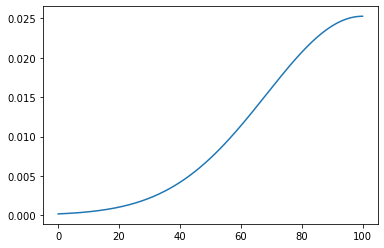

In [83]:
#Bare gaussian:
plt.plot(g,p0_unreg)

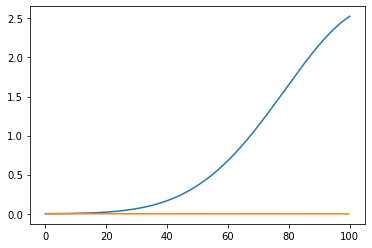

In [84]:
#Gaussian multiplied by g:
plt.plot(g,g*p0_unreg)
plt.plot(g[1:-1],derv2(g*p0_unreg,dg))

Double derivative of the form $\dfrac{\partial^2}{\partial x^2} x p(x)$:

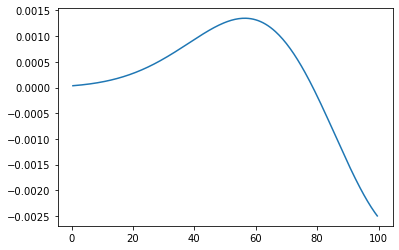

In [85]:
#Double derivative:
exact_soln = derv2(g*p0_unreg,dg)
plt.plot(g[1:-1],exact_soln)

Now, term of form $\langle x \rangle \dfrac{\partial^2}{\partial x^2} p(x)$:

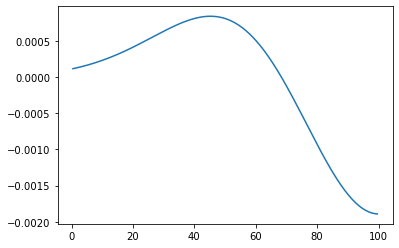

In [86]:
g_mean = mean_wrt_P(g,p0_unreg,g)
sreyams_approx = g_mean*derv2(p0_unreg,dg)
plt.plot(g[1:-1],sreyams_approx)

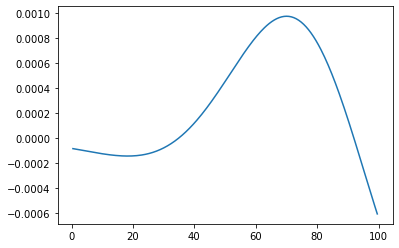

In [77]:
#Difference between exact solution and my approximation:
plt.plot(g[1:-1],exact_soln-sreyams_approx)

In [87]:
#Scale of the error:
Nt*dt*alpha*K*np.trapz(exact_soln-sreyams_approx,dx=dg)

5.330862734374774